# **RNN From Scratch**

In [267]:
import numpy as np
import matplotlib.pyplot as plt

In [268]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0, keepdims=True)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [269]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """

    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)  # (n_a, m)
    yt_pred = softmax(np.dot(Wya, a_next) + by)                   # (n_y, m)
    cache = (a_next, a_prev, xt, parameters)

    return a_next, yt_pred, cache

In [270]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing parameters matrices

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """

    caches = []
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape

    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))

    a_next = a0
    for t in range(T_x):
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        a[:, :, t] = a_next
        y_pred[:, :, t] = yt_pred
        caches.append(cache)

    caches = (caches, x)

    return a, y_pred, caches

In [271]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for a single RNN cell (1 time-step).

    Arguments:
    da_next -- Gradients of the next hidden state, of shape (n_a, m)
    cache -- Tuple of values (a_next, a_prev, xt, parameters) from forward pass

    Returns:
    gradients -- Dictionary containing:
        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
        da_prev -- Gradient w.r.t. previous hidden state, of shape (n_a, m)
        dWax -- Gradient w.r.t. input weight matrix, shape (n_a, n_x)
        dWaa -- Gradient w.r.t. hidden state weight matrix, shape (n_a, n_a)
        dba -- Gradient w.r.t. bias vector, shape (n_a, 1)
    """
    # Shapes from forward
    # xt     → (n_x, m)
    # a_prev → (n_a, m)
    # Wax    → (n_a, n_x)
    # Waa    → (n_a, n_a)
    # Wya    → (n_y, n_a)
    # ba     → (n_a, 1)
    # by     → (n_y, 1)

    (a_next, a_prev, xt, parameters) = cache

    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # Derivative through tanh activation
    dtanh = (1 - a_next**2) * da_next     # (n_a, m)

    # Gradients
    dxt    = np.dot(Wax.T, dtanh)         # (n_x, m)
    dWax   = np.dot(dtanh, xt.T)          # (n_a, n_x)
    da_prev = np.dot(Waa.T, dtanh)        # (n_a, m)
    dWaa   = np.dot(dtanh, a_prev.T)      # (n_a, n_a)
    dba    = np.sum(dtanh, axis=1, keepdims=True)  # (n_a, 1)

    gradients = {
        "dxt": dxt,
        "da_prev": da_prev,
        "dWax": dWax,
        "dWaa": dWaa,
        "dba": dba
    }

    return gradients

In [272]:
def rnn_backward(da, caches):
    """
    Implements the backward pass for a vanilla RNN over an entire sequence.

    Arguments:
    da -- Gradients of all hidden states, shape (n_a, m, T_x)
    caches -- Tuple of values from rnn_forward (list of caches, x)

    Returns:
    gradients -- Dictionary with:
        dx -- Gradient of input data, shape (n_x, m, T_x)
        da0 -- Gradient of initial hidden state, shape (n_a, m)
        dWax -- Gradient of input weights, shape (n_a, n_x)
        dWaa -- Gradient of hidden weights, shape (n_a, n_a)
        dba -- Gradient of bias vector, shape (n_a, 1)
    """

    caches_list, x = caches
    (a1, a0, xt, parameters) = caches_list[0]

    n_a, m, T_x = da.shape
    n_x, _ = xt.shape

    dx    = np.zeros((n_x, m, T_x))
    dWax  = np.zeros((n_a, n_x))
    dWaa  = np.zeros((n_a, n_a))
    dba   = np.zeros((n_a, 1))
    da0   = np.zeros((n_a, m))

    da_next = np.zeros((n_a, m))

    for t in reversed(range(T_x)):
        da_current = da[:, :, t] + da_next
        gradients = rnn_cell_backward(da_current, caches_list[t])

        dx[:, :, t] = gradients["dxt"]
        dWax += gradients["dWax"]
        dWaa += gradients["dWaa"]
        dba  += gradients["dba"]
        da_next = gradients["da_prev"]

    da0 = da_next

    gradients = {
        "dx": dx,
        "da0": da0,
        "dWax": dWax,
        "dWaa": dWaa,
        "dba": dba
    }

    return gradients

In [273]:
data = (
    "deep learning is a powerful tool in ai. "
    "rnn models process sequential data like text. "
    "this is a custom character-level rnn trained from scratch. "
    "you are building backprop through time manually. "
    "it is hard but also rewarding. "
    "this model learns to predict next characters. "
    "eventually it will generate realistic text samples."
)

In [274]:
chars = sorted(list(set(data)))
vocab_size = len(chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

print("Vocab:", chars)

Vocab: [' ', '-', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [275]:
def create_dataset(data, seq_length=10):
    examples = []
    for i in range(len(data) - seq_length):
        x_seq = data[i:i+seq_length]       # x_seq: a sequence of characters
        y_seq = data[i+1:i+1+seq_length]   # y_seq: the same sequence shifted one character forward
        examples.append((x_seq, y_seq))
    return examples

In [276]:
examples = create_dataset(data, seq_length=10)
examples

[('deep learn', 'eep learni'),
 ('eep learni', 'ep learnin'),
 ('ep learnin', 'p learning'),
 ('p learning', ' learning '),
 (' learning ', 'learning i'),
 ('learning i', 'earning is'),
 ('earning is', 'arning is '),
 ('arning is ', 'rning is a'),
 ('rning is a', 'ning is a '),
 ('ning is a ', 'ing is a p'),
 ('ing is a p', 'ng is a po'),
 ('ng is a po', 'g is a pow'),
 ('g is a pow', ' is a powe'),
 (' is a powe', 'is a power'),
 ('is a power', 's a powerf'),
 ('s a powerf', ' a powerfu'),
 (' a powerfu', 'a powerful'),
 ('a powerful', ' powerful '),
 (' powerful ', 'powerful t'),
 ('powerful t', 'owerful to'),
 ('owerful to', 'werful too'),
 ('werful too', 'erful tool'),
 ('erful tool', 'rful tool '),
 ('rful tool ', 'ful tool i'),
 ('ful tool i', 'ul tool in'),
 ('ul tool in', 'l tool in '),
 ('l tool in ', ' tool in a'),
 (' tool in a', 'tool in ai'),
 ('tool in ai', 'ool in ai.'),
 ('ool in ai.', 'ol in ai. '),
 ('ol in ai. ', 'l in ai. r'),
 ('l in ai. r', ' in ai. rn'),
 (' in a

In [277]:
def vectorize_example(x_seq, y_seq, char_to_ix, vocab_size):
    T_x = len(x_seq)
    x = np.zeros((vocab_size, 1, T_x))
    y = np.zeros((vocab_size, 1, T_x))

    for t in range(T_x):
        x[char_to_ix[x_seq[t]], 0, t] = 1
        y[char_to_ix[y_seq[t]], 0, t] = 1

    return x, y

In [278]:
n_x = vocab_size              # input feature size (one-hot)
n_y = vocab_size              # output size (also one-hot)
n_a = 64                      # hidden size

In [279]:
def initialize_parameters(n_a, n_x, n_y):
    np.random.seed(1)
    parameters = {}
    parameters['Wax'] = np.random.randn(n_a, n_x) * 0.01
    parameters['Waa'] = np.random.randn(n_a, n_a) * 0.01
    parameters['Wya'] = np.random.randn(n_y, n_a) * 0.01
    parameters['ba'] = np.zeros((n_a, 1))
    parameters['by'] = np.zeros((n_y, 1))
    return parameters

parameters = initialize_parameters(n_a, n_x, n_y)

In [280]:
batch_size = 16

In [281]:
a0 = np.zeros((n_a, batch_size))
losses = []

In [283]:
for epoch in range(3000):

    # ---- Move this entire block inside the epoch loop ----
    idxs = np.random.choice(len(examples), size=batch_size)
    x_batch = []
    y_batch = []

    for i in idxs:
        x_seq, y_seq = examples[i]
        x_vec, y_vec = vectorize_example(x_seq, y_seq, char_to_ix, vocab_size)  # (n_x, 1, T_x)
        x_batch.append(x_vec)
        y_batch.append(y_vec)

    # Stack batch on axis=1 (batch dimension)
    x = np.concatenate(x_batch, axis=1)  # (n_x, batch_size, T_x)
    y = np.concatenate(y_batch, axis=1)  # (n_y, batch_size, T_x)

    T_x = x.shape[2]

    a, y_pred, caches = rnn_forward(x, a0, parameters)

    dy = y_pred - y
    da = np.zeros_like(a)
    for t in range(T_x):
        da[:, :, t] = np.dot(parameters["Wya"].T, dy[:, :, t])

    gradients = rnn_backward(da, caches)

    dWya = np.zeros_like(parameters["Wya"])
    dby  = np.zeros_like(parameters["by"])
    for t in range(T_x):
        dWya += np.dot(dy[:, :, t], a[:, :, t].T)
        dby  += np.sum(dy[:, :, t], axis=1, keepdims=True)

    gradients["dWya"] = dWya
    gradients["dby"] = dby

    learning_rate = 0.005
    for param in ["Wax", "Waa", "Wya", "ba", "by"]:
        parameters[param] -= learning_rate * gradients["d" + param]

    # Loss tracking
    loss = -np.sum(y * np.log(y_pred + 1e-8)) / T_x
    losses.append(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 7.3980
Epoch 100, Loss: 5.9421
Epoch 200, Loss: 6.3048
Epoch 300, Loss: 6.4067
Epoch 400, Loss: 5.8040
Epoch 500, Loss: 5.6490
Epoch 600, Loss: 5.4164
Epoch 700, Loss: 6.6380
Epoch 800, Loss: 6.5366
Epoch 900, Loss: 5.5888
Epoch 1000, Loss: 5.1831
Epoch 1100, Loss: 4.5512
Epoch 1200, Loss: 5.1964
Epoch 1300, Loss: 4.1101
Epoch 1400, Loss: 4.8537
Epoch 1500, Loss: 5.4864
Epoch 1600, Loss: 5.0220
Epoch 1700, Loss: 5.4775
Epoch 1800, Loss: 4.9656
Epoch 1900, Loss: 5.2409
Epoch 2000, Loss: 4.8845
Epoch 2100, Loss: 5.2962
Epoch 2200, Loss: 4.8059
Epoch 2300, Loss: 5.1925
Epoch 2400, Loss: 5.3983
Epoch 2500, Loss: 5.4611
Epoch 2600, Loss: 5.2205
Epoch 2700, Loss: 5.2736
Epoch 2800, Loss: 5.6061
Epoch 2900, Loss: 4.8267


In [284]:
def sample(parameters, char_to_ix, seed_char, length=10, temperature=1.0):
    """
    Generates a sequence of characters using stochastic sampling.

    Arguments:
    parameters -- trained model parameters
    char_to_ix -- dictionary mapping characters to indices
    seed_char -- starting character
    length -- number of characters to generate
    temperature -- controls randomness: lower = greedy, higher = more random

    Returns:
    output -- generated string of characters
    """

    n_a = parameters["Waa"].shape[0]
    vocab_size = len(char_to_ix)
    a_prev = np.zeros((n_a, 1))
    idx_to_char = {i: ch for ch, i in char_to_ix.items()}

    current_char = seed_char
    output = current_char

    for t in range(length):
        # One-hot input vector
        x = np.zeros((vocab_size, 1))
        x[char_to_ix[current_char]] = 1

        # RNN one-step forward
        a_next, y_pred, _ = rnn_cell_forward(x, a_prev, parameters)

        # Sample index from probability distribution
        idx = np.random.choice(range(vocab_size), p=y_pred.ravel())

        # Get character
        next_char = idx_to_char[idx]
        output += next_char

        # Update for next step
        a_prev = a_next
        current_char = next_char

    return output

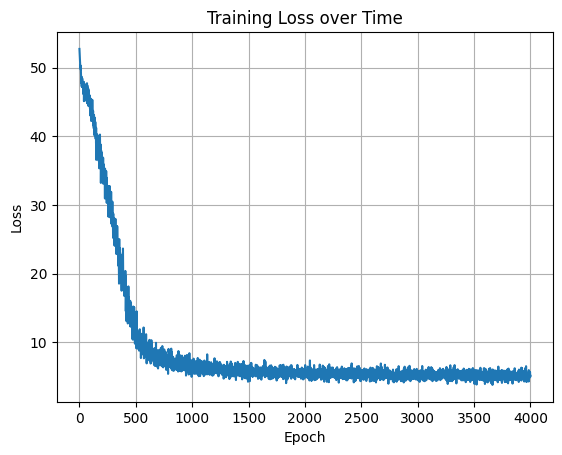

In [285]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.show()

In [289]:
sample_m = sample(parameters, char_to_ix, seed_char='m', length=200)
sample_t = sample(parameters, char_to_ix, seed_char='t', length=200)
sample_r = sample(parameters, char_to_ix, seed_char='r', length=200)

print("Sample starting with 'm':")
print(sample_m)
print("\nSample starting with 't':")
print(sample_t)
print("\nSample starting with 'r':")
print(sample_r)

Sample starting with 'm':
manually. it is hard but also rewarding. this model learns to predict next characters. eventually it will generate realistic text samples. scearns to predict next character-level rnn trained from scrat

Sample starting with 't':
trained from scratch. you are building backprop through time manually. it is hard but also rewarding. this model learns to predict next character-level rnn trained from scratch. you are building backpr

Sample starting with 'r':
rewarding. this model learns to predict next characters. eventually it will generate realistic text samples. shqodict next. this is a custom characters. eventually it will generate realistic text. this
